In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU device:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
Number of GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA RTX A2000


In [ ]:
import transformers
import accelerate

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")


C:\Users\aaa\anaconda3\envs\ml_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transformers version: 4.45.2
Accelerate version: 1.0.1


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

# Load data
data = pd.read_csv(r"C:\Users\aaa\Downloads\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']
X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()

    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)

        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)

    epoch_time = time.time() - epoch_start_time

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

bert_base_model_save_path = 'bert_model_trained.pth'
torch.save(model.state_dict(), bert_base_model_save_path)

print(f"Model saved to {bert_base_model_save_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:32<00:00,  1.21it/s]


Epoch 1/10, Train Loss: 0.0117, Train Acc: 0.7173, Train Precision: 0.7223, Train Recall: 0.7173, Train F1: 0.7176, Valid Loss: 0.0057, Valid Acc: 0.8721, Valid Precision: 0.8753, Valid Recall: 0.8721, Valid F1: 0.8721, Epoch Time: 100.61 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.20it/s]


Epoch 2/10, Train Loss: 0.0042, Train Acc: 0.9106, Train Precision: 0.9106, Train Recall: 0.9106, Train F1: 0.9102, Valid Loss: 0.0025, Valid Acc: 0.9397, Valid Precision: 0.9399, Valid Recall: 0.9397, Valid F1: 0.9396, Epoch Time: 101.78 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch 3/10, Train Loss: 0.0020, Train Acc: 0.9575, Train Precision: 0.9574, Train Recall: 0.9575, Train F1: 0.9574, Valid Loss: 0.0017, Valid Acc: 0.9598, Valid Precision: 0.9596, Valid Recall: 0.9598, Valid F1: 0.9597, Epoch Time: 102.05 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch 4/10, Train Loss: 0.0012, Train Acc: 0.9721, Train Precision: 0.9721, Train Recall: 0.9721, Train F1: 0.9720, Valid Loss: 0.0015, Valid Acc: 0.9670, Valid Precision: 0.9677, Valid Recall: 0.9670, Valid F1: 0.9667, Epoch Time: 102.03 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch 5/10, Train Loss: 0.0010, Train Acc: 0.9792, Train Precision: 0.9792, Train Recall: 0.9792, Train F1: 0.9792, Valid Loss: 0.0012, Valid Acc: 0.9709, Valid Precision: 0.9710, Valid Recall: 0.9709, Valid F1: 0.9708, Epoch Time: 102.03 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch 6/10, Train Loss: 0.0009, Train Acc: 0.9841, Train Precision: 0.9841, Train Recall: 0.9841, Train F1: 0.9841, Valid Loss: 0.0019, Valid Acc: 0.9665, Valid Precision: 0.9667, Valid Recall: 0.9665, Valid F1: 0.9664, Epoch Time: 102.03 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch 7/10, Train Loss: 0.0006, Train Acc: 0.9867, Train Precision: 0.9867, Train Recall: 0.9867, Train F1: 0.9867, Valid Loss: 0.0007, Valid Acc: 0.9866, Valid Precision: 0.9866, Valid Recall: 0.9866, Valid F1: 0.9866, Epoch Time: 102.04 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch 8/10, Train Loss: 0.0004, Train Acc: 0.9916, Train Precision: 0.9916, Train Recall: 0.9916, Train F1: 0.9916, Valid Loss: 0.0011, Valid Acc: 0.9771, Valid Precision: 0.9776, Valid Recall: 0.9771, Valid F1: 0.9772, Epoch Time: 102.05 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.19it/s]


Epoch 9/10, Train Loss: 0.0005, Train Acc: 0.9895, Train Precision: 0.9895, Train Recall: 0.9895, Train F1: 0.9895, Valid Loss: 0.0009, Valid Acc: 0.9793, Valid Precision: 0.9794, Valid Recall: 0.9793, Valid F1: 0.9793, Epoch Time: 102.04 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.20it/s]


Epoch 10/10, Train Loss: 0.0004, Train Acc: 0.9930, Train Precision: 0.9930, Train Recall: 0.9930, Train F1: 0.9930, Valid Loss: 0.0009, Valid Acc: 0.9832, Valid Precision: 0.9833, Valid Recall: 0.9832, Valid F1: 0.9832, Epoch Time: 101.97 seconds
Total training time: 1018.64 seconds
Model saved to bert_model_trained.pth


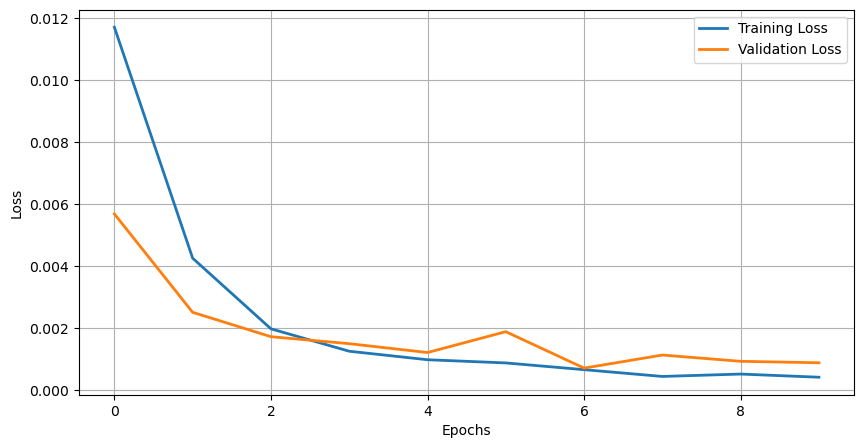

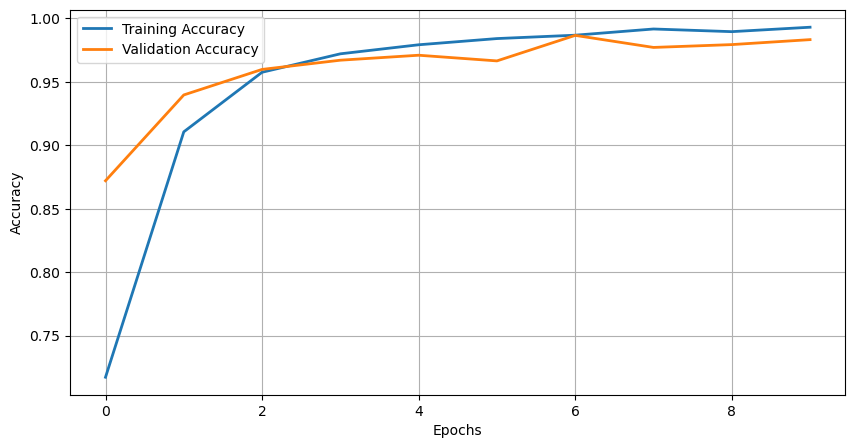

In [ ]:
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

data = pd.read_csv(r"C:\Users\aaa\Downloads\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

distilbert_model_save_path = 'distilbert_model_trained.pth'
torch.save(model.state_dict(), distilbert_model_save_path)

print(f"Model saved to {distilbert_model_save_path}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:46<00:00,  2.39it/s]


Epoch 1/10, Train Loss: 0.0115, Train Acc: 0.7209, Train Precision: 0.7227, Train Recall: 0.7209, Train F1: 0.7211, Valid Loss: 0.0054, Valid Acc: 0.8832, Valid Precision: 0.8888, Valid Recall: 0.8832, Valid F1: 0.8820, Epoch Time: 51.11 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:47<00:00,  2.37it/s]


Epoch 2/10, Train Loss: 0.0041, Train Acc: 0.9072, Train Precision: 0.9074, Train Recall: 0.9072, Train F1: 0.9065, Valid Loss: 0.0025, Valid Acc: 0.9469, Valid Precision: 0.9474, Valid Recall: 0.9469, Valid F1: 0.9469, Epoch Time: 51.40 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:47<00:00,  2.34it/s]


Epoch 3/10, Train Loss: 0.0022, Train Acc: 0.9519, Train Precision: 0.9518, Train Recall: 0.9519, Train F1: 0.9517, Valid Loss: 0.0027, Valid Acc: 0.9346, Valid Precision: 0.9365, Valid Recall: 0.9346, Valid F1: 0.9351, Epoch Time: 52.08 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.33it/s]


Epoch 4/10, Train Loss: 0.0013, Train Acc: 0.9730, Train Precision: 0.9730, Train Recall: 0.9730, Train F1: 0.9730, Valid Loss: 0.0018, Valid Acc: 0.9536, Valid Precision: 0.9553, Valid Recall: 0.9536, Valid F1: 0.9535, Epoch Time: 52.45 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.32it/s]


Epoch 5/10, Train Loss: 0.0011, Train Acc: 0.9770, Train Precision: 0.9769, Train Recall: 0.9770, Train F1: 0.9769, Valid Loss: 0.0016, Valid Acc: 0.9587, Valid Precision: 0.9593, Valid Recall: 0.9587, Valid F1: 0.9586, Epoch Time: 52.63 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch 6/10, Train Loss: 0.0010, Train Acc: 0.9788, Train Precision: 0.9787, Train Recall: 0.9788, Train F1: 0.9788, Valid Loss: 0.0011, Valid Acc: 0.9771, Valid Precision: 0.9771, Valid Recall: 0.9771, Valid F1: 0.9771, Epoch Time: 52.74 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch 7/10, Train Loss: 0.0005, Train Acc: 0.9901, Train Precision: 0.9901, Train Recall: 0.9901, Train F1: 0.9901, Valid Loss: 0.0008, Valid Acc: 0.9838, Valid Precision: 0.9838, Valid Recall: 0.9838, Valid F1: 0.9838, Epoch Time: 52.82 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch 8/10, Train Loss: 0.0004, Train Acc: 0.9929, Train Precision: 0.9929, Train Recall: 0.9929, Train F1: 0.9929, Valid Loss: 0.0011, Valid Acc: 0.9782, Valid Precision: 0.9784, Valid Recall: 0.9782, Valid F1: 0.9782, Epoch Time: 52.79 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch 9/10, Train Loss: 0.0004, Train Acc: 0.9927, Train Precision: 0.9927, Train Recall: 0.9927, Train F1: 0.9927, Valid Loss: 0.0013, Valid Acc: 0.9754, Valid Precision: 0.9754, Valid Recall: 0.9754, Valid F1: 0.9753, Epoch Time: 52.83 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.31it/s]


Epoch 10/10, Train Loss: 0.0003, Train Acc: 0.9954, Train Precision: 0.9954, Train Recall: 0.9954, Train F1: 0.9954, Valid Loss: 0.0007, Valid Acc: 0.9866, Valid Precision: 0.9867, Valid Recall: 0.9866, Valid F1: 0.9866, Epoch Time: 52.80 seconds
Total training time: 523.69 seconds
Model saved to distilbert_model_trained.pth


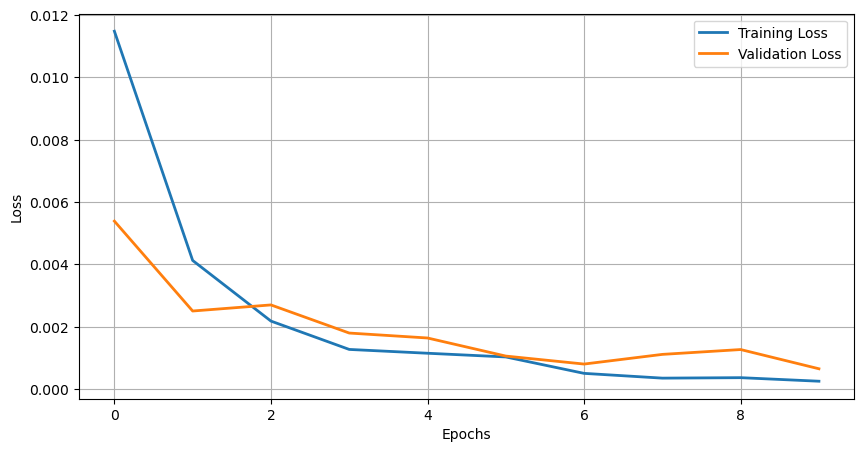

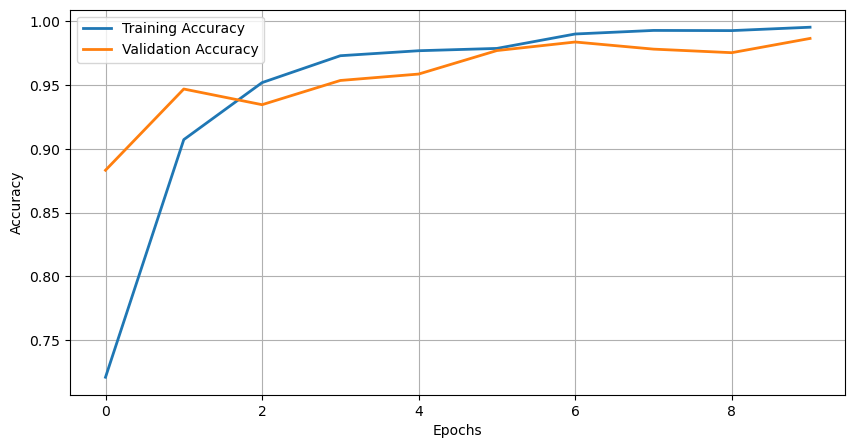

In [ ]:
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import AlbertTokenizer, AlbertForSequenceClassification
import numpy as np
from tqdm import tqdm
import time

data = pd.read_csv(r"C:\Users\aaa\Downloads\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=4)
device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)
    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)
    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")
albert_model_save_path = 'albert_model_trained1.pth'
torch.save(model.state_dict(), albert_model_save_path)

print(f"Model saved to {albert_model_save_path}")

C:\Users\aaa\anaconda3\envs\ml_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:05<00:00,  1.65s/it]


Epoch 1/10, Train Loss: 0.0145, Train Acc: 0.6339, Train Precision: 0.6378, Train Recall: 0.6339, Train F1: 0.6340, Valid Loss: 0.0091, Valid Acc: 0.8056, Valid Precision: 0.8320, Valid Recall: 0.8056, Valid F1: 0.8082, Epoch Time: 198.95 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:12<00:00,  1.72s/it]


Epoch 2/10, Train Loss: 0.0076, Train Acc: 0.8339, Train Precision: 0.8382, Train Recall: 0.8339, Train F1: 0.8328, Valid Loss: 0.0058, Valid Acc: 0.8743, Valid Precision: 0.8789, Valid Recall: 0.8743, Valid F1: 0.8729, Epoch Time: 207.15 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:15<00:00,  1.74s/it]


Epoch 3/10, Train Loss: 0.0049, Train Acc: 0.8908, Train Precision: 0.8907, Train Recall: 0.8908, Train F1: 0.8896, Valid Loss: 0.0037, Valid Acc: 0.9173, Valid Precision: 0.9171, Valid Recall: 0.9173, Valid F1: 0.9166, Epoch Time: 210.47 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:16<00:00,  1.75s/it]


Epoch 4/10, Train Loss: 0.0032, Train Acc: 0.9269, Train Precision: 0.9264, Train Recall: 0.9269, Train F1: 0.9264, Valid Loss: 0.0029, Valid Acc: 0.9330, Valid Precision: 0.9328, Valid Recall: 0.9330, Valid F1: 0.9324, Epoch Time: 211.78 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:13<00:00,  1.72s/it]


Epoch 5/10, Train Loss: 0.0025, Train Acc: 0.9480, Train Precision: 0.9478, Train Recall: 0.9480, Train F1: 0.9478, Valid Loss: 0.0029, Valid Acc: 0.9419, Valid Precision: 0.9432, Valid Recall: 0.9419, Valid F1: 0.9419, Epoch Time: 208.13 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:12<00:00,  1.72s/it]


Epoch 6/10, Train Loss: 0.0025, Train Acc: 0.9464, Train Precision: 0.9462, Train Recall: 0.9464, Train F1: 0.9462, Valid Loss: 0.0026, Valid Acc: 0.9458, Valid Precision: 0.9459, Valid Recall: 0.9458, Valid F1: 0.9453, Epoch Time: 207.45 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:12<00:00,  1.72s/it]


Epoch 7/10, Train Loss: 0.0019, Train Acc: 0.9584, Train Precision: 0.9584, Train Recall: 0.9584, Train F1: 0.9583, Valid Loss: 0.0020, Valid Acc: 0.9508, Valid Precision: 0.9508, Valid Recall: 0.9508, Valid F1: 0.9507, Epoch Time: 207.05 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:12<00:00,  1.72s/it]


Epoch 8/10, Train Loss: 0.0013, Train Acc: 0.9726, Train Precision: 0.9726, Train Recall: 0.9726, Train F1: 0.9726, Valid Loss: 0.0026, Valid Acc: 0.9380, Valid Precision: 0.9377, Valid Recall: 0.9380, Valid F1: 0.9376, Epoch Time: 207.22 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:15<00:00,  1.75s/it]


Epoch 9/10, Train Loss: 0.0012, Train Acc: 0.9749, Train Precision: 0.9749, Train Recall: 0.9749, Train F1: 0.9748, Valid Loss: 0.0021, Valid Acc: 0.9514, Valid Precision: 0.9545, Valid Recall: 0.9514, Valid F1: 0.9513, Epoch Time: 210.64 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:13<00:00,  1.73s/it]


Epoch 10/10, Train Loss: 0.0007, Train Acc: 0.9863, Train Precision: 0.9863, Train Recall: 0.9863, Train F1: 0.9863, Valid Loss: 0.0015, Valid Acc: 0.9687, Valid Precision: 0.9686, Valid Recall: 0.9687, Valid F1: 0.9686, Epoch Time: 208.81 seconds
Total training time: 2077.65 seconds
Model saved to albert_model_trained1.pth


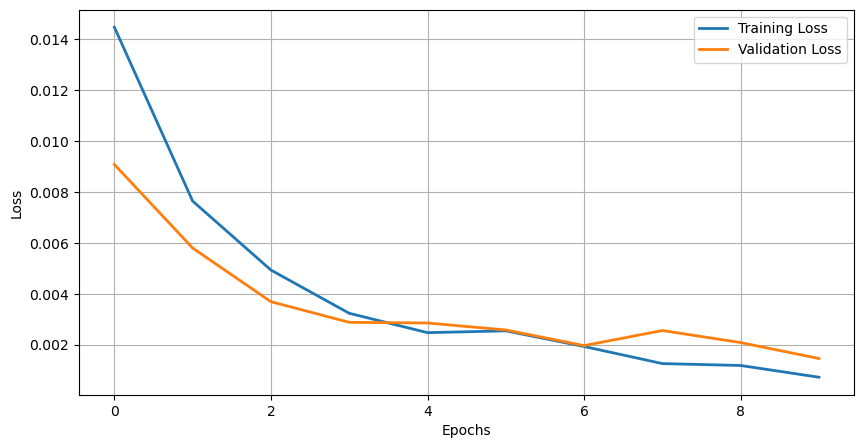

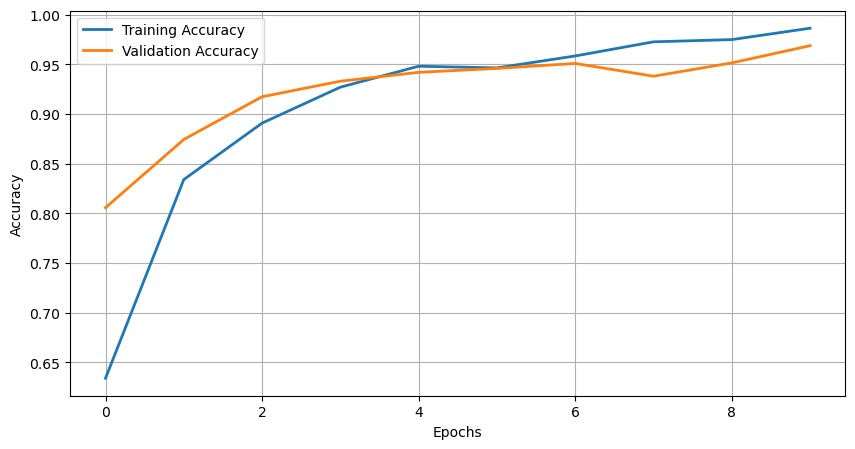

In [ ]:
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

data = pd.read_csv(r"C:\Users\aaa\Downloads\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]

X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")
roberta_model_save_path = 'roberta_model_trained.pth'
torch.save(model.state_dict(), roberta_model_save_path)

print(f"Model saved to {roberta_model_save_path}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:33<00:00,  1.20it/s]


Epoch 1/10, Train Loss: 0.0122, Train Acc: 0.6879, Train Precision: 0.6928, Train Recall: 0.6879, Train F1: 0.6888, Valid Loss: 0.0065, Valid Acc: 0.8480, Valid Precision: 0.8527, Valid Recall: 0.8480, Valid F1: 0.8488, Epoch Time: 101.69 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:35<00:00,  1.17it/s]


Epoch 2/10, Train Loss: 0.0052, Train Acc: 0.8864, Train Precision: 0.8866, Train Recall: 0.8864, Train F1: 0.8856, Valid Loss: 0.0033, Valid Acc: 0.9229, Valid Precision: 0.9246, Valid Recall: 0.9229, Valid F1: 0.9222, Epoch Time: 103.67 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 3/10, Train Loss: 0.0034, Train Acc: 0.9215, Train Precision: 0.9213, Train Recall: 0.9215, Train F1: 0.9210, Valid Loss: 0.0028, Valid Acc: 0.9352, Valid Precision: 0.9352, Valid Recall: 0.9352, Valid F1: 0.9347, Epoch Time: 104.40 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 4/10, Train Loss: 0.0023, Train Acc: 0.9452, Train Precision: 0.9451, Train Recall: 0.9452, Train F1: 0.9450, Valid Loss: 0.0019, Valid Acc: 0.9542, Valid Precision: 0.9541, Valid Recall: 0.9542, Valid F1: 0.9541, Epoch Time: 104.46 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 5/10, Train Loss: 0.0016, Train Acc: 0.9637, Train Precision: 0.9636, Train Recall: 0.9637, Train F1: 0.9636, Valid Loss: 0.0017, Valid Acc: 0.9642, Valid Precision: 0.9643, Valid Recall: 0.9642, Valid F1: 0.9643, Epoch Time: 104.59 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 6/10, Train Loss: 0.0011, Train Acc: 0.9746, Train Precision: 0.9746, Train Recall: 0.9746, Train F1: 0.9745, Valid Loss: 0.0013, Valid Acc: 0.9743, Valid Precision: 0.9743, Valid Recall: 0.9743, Valid F1: 0.9743, Epoch Time: 104.50 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 7/10, Train Loss: 0.0013, Train Acc: 0.9712, Train Precision: 0.9712, Train Recall: 0.9712, Train F1: 0.9712, Valid Loss: 0.0020, Valid Acc: 0.9587, Valid Precision: 0.9609, Valid Recall: 0.9587, Valid F1: 0.9587, Epoch Time: 104.46 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.16it/s]


Epoch 8/10, Train Loss: 0.0008, Train Acc: 0.9817, Train Precision: 0.9817, Train Recall: 0.9817, Train F1: 0.9817, Valid Loss: 0.0010, Valid Acc: 0.9765, Valid Precision: 0.9766, Valid Recall: 0.9765, Valid F1: 0.9765, Epoch Time: 104.39 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.17it/s]


Epoch 9/10, Train Loss: 0.0007, Train Acc: 0.9855, Train Precision: 0.9855, Train Recall: 0.9855, Train F1: 0.9855, Valid Loss: 0.0013, Valid Acc: 0.9715, Valid Precision: 0.9715, Valid Recall: 0.9715, Valid F1: 0.9715, Epoch Time: 104.30 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:36<00:00,  1.17it/s]


Epoch 10/10, Train Loss: 0.0008, Train Acc: 0.9825, Train Precision: 0.9825, Train Recall: 0.9825, Train F1: 0.9825, Valid Loss: 0.0010, Valid Acc: 0.9799, Valid Precision: 0.9799, Valid Recall: 0.9799, Valid F1: 0.9799, Epoch Time: 104.22 seconds
Total training time: 1040.68 seconds
Model saved to roberta_model_trained.pth


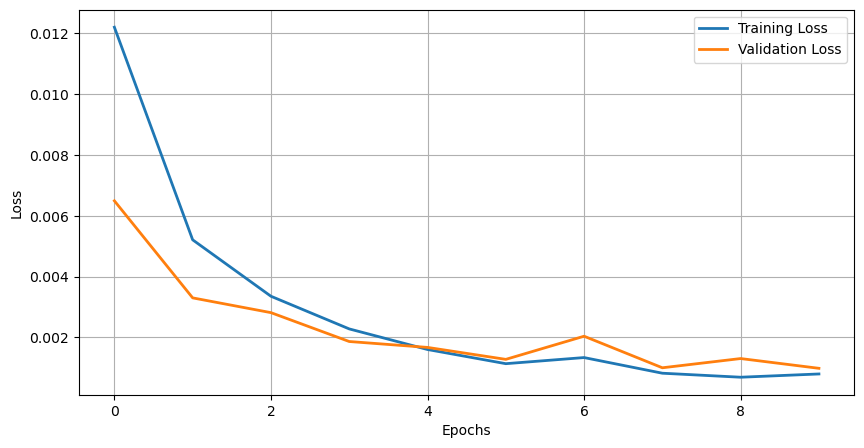

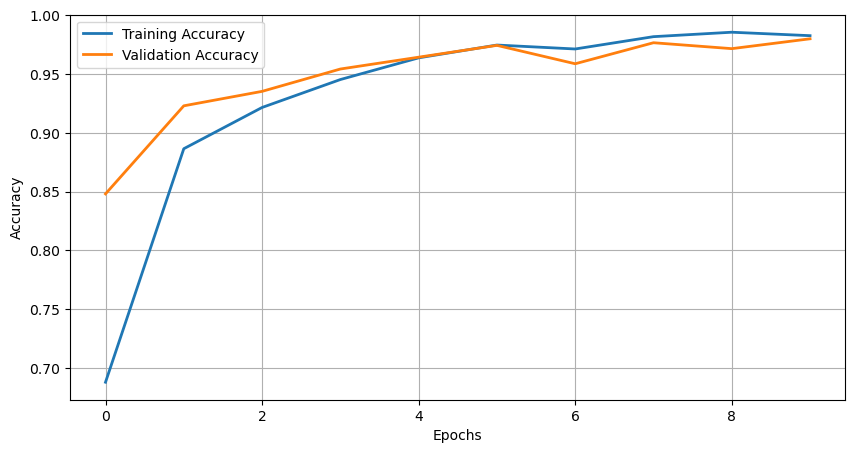

In [ ]:
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

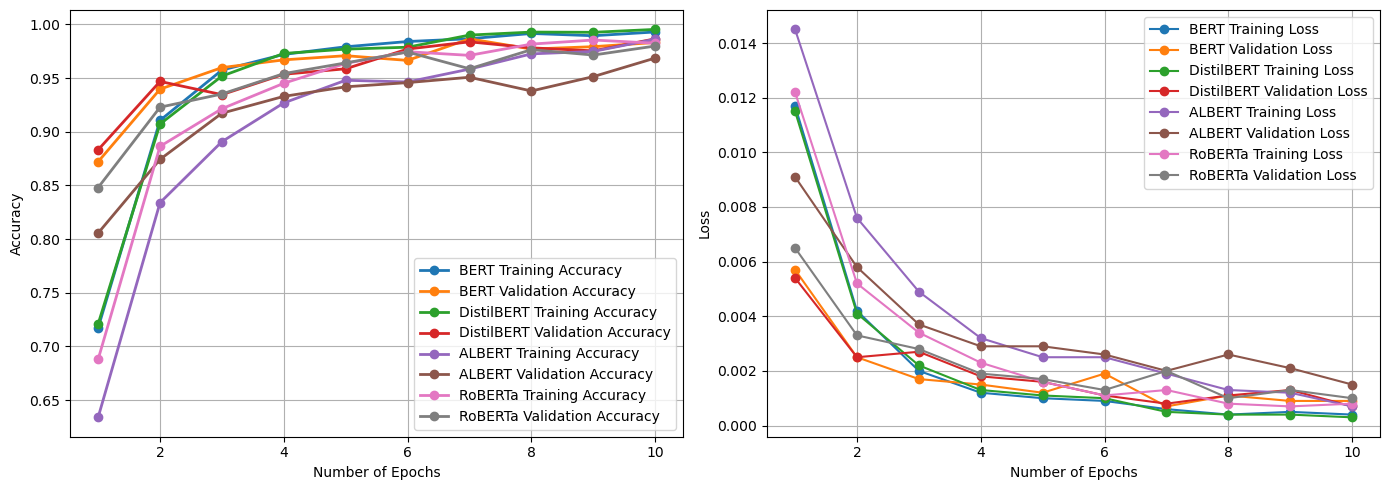

In [ ]:
#summarized plot.
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

bert_train_loss = [0.0117, 0.0042, 0.0020, 0.0012, 0.0010, 0.0009, 0.0006, 0.0004, 0.0005, 0.0004]
bert_val_loss = [0.0057, 0.0025, 0.0017, 0.0015, 0.0012, 0.0019, 0.0007, 0.0011, 0.0009, 0.0009]
bert_train_acc = [0.7173, 0.9106, 0.9575, 0.9721, 0.9792, 0.9841, 0.9867, 0.9916, 0.9895, 0.9930]
bert_val_acc = [0.8721, 0.9397, 0.9598, 0.9670, 0.9709, 0.9665, 0.9866, 0.9771, 0.9793, 0.9832]

distilbert_train_loss = [0.0115, 0.0041, 0.0022, 0.0013, 0.0011, 0.0010, 0.0005, 0.0004, 0.0004, 0.0003]
distilbert_val_loss = [0.0054, 0.0025, 0.0027, 0.0018, 0.0016, 0.0011, 0.0008, 0.0011, 0.0013, 0.0007]
distilbert_train_acc = [0.7209, 0.9072, 0.9519, 0.9730, 0.9770, 0.9788, 0.9901, 0.9929, 0.9927, 0.9954]
distilbert_val_acc = [0.8832, 0.9469, 0.9346, 0.9536, 0.9587, 0.9771, 0.9838, 0.9782, 0.9754, 0.9866]

albert_train_loss = [0.0145, 0.0076, 0.0049, 0.0032, 0.0025, 0.0025, 0.0019, 0.0013, 0.0012, 0.0007]
albert_val_loss = [0.0091, 0.0058, 0.0037, 0.0029, 0.0029, 0.0026, 0.0020, 0.0026, 0.0021, 0.0015]
albert_train_acc = [0.6339, 0.8339, 0.8908, 0.9269, 0.9480, 0.9464, 0.9584, 0.9726, 0.9749, 0.9863]
albert_val_acc = [0.8056, 0.8743, 0.9173, 0.9330, 0.9419, 0.9458, 0.9508, 0.9380, 0.9514, 0.9687]

roberta_train_loss = [0.0122, 0.0052, 0.0034, 0.0023, 0.0016, 0.0011, 0.0013, 0.0008, 0.0007, 0.0008]
roberta_val_loss = [0.0065, 0.0033, 0.0028, 0.0019, 0.0017, 0.0013, 0.0020, 0.0010, 0.0013, 0.0010]
roberta_train_acc = [0.6879, 0.8864, 0.9215, 0.9452, 0.9637, 0.9746, 0.9712, 0.9817, 0.9855, 0.9825]
roberta_val_acc = [0.8480, 0.9229, 0.9352, 0.9542, 0.9642, 0.9743, 0.9587, 0.9765, 0.9715, 0.9799]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, bert_train_acc, 'o-', label="BERT Training Accuracy", linewidth=2)
plt.plot(epochs, bert_val_acc, 'o-', label="BERT Validation Accuracy", linewidth=2)
plt.plot(epochs, distilbert_train_acc, 'o-', label="DistilBERT Training Accuracy", linewidth=2)
plt.plot(epochs, distilbert_val_acc, 'o-', label="DistilBERT Validation Accuracy", linewidth=2)
plt.plot(epochs, albert_train_acc, 'o-', label="ALBERT Training Accuracy", linewidth=2)
plt.plot(epochs, albert_val_acc, 'o-', label="ALBERT Validation Accuracy", linewidth=2)
plt.plot(epochs, roberta_train_acc, 'o-', label="RoBERTa Training Accuracy", linewidth=2)
plt.plot(epochs, roberta_val_acc, 'o-', label="RoBERTa Validation Accuracy", linewidth=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, bert_train_loss, 'o-', label="BERT Training Loss")
plt.plot(epochs, bert_val_loss, 'o-', label="BERT Validation Loss")
plt.plot(epochs, distilbert_train_loss, 'o-', label="DistilBERT Training Loss")
plt.plot(epochs, distilbert_val_loss, 'o-', label="DistilBERT Validation Loss")
plt.plot(epochs, albert_train_loss, 'o-', label="ALBERT Training Loss")
plt.plot(epochs, albert_val_loss, 'o-', label="ALBERT Validation Loss")
plt.plot(epochs, roberta_train_loss, 'o-', label="RoBERTa Training Loss")
plt.plot(epochs, roberta_val_loss, 'o-', label="RoBERTa Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid()

plt.tight_layout()
plt.show()

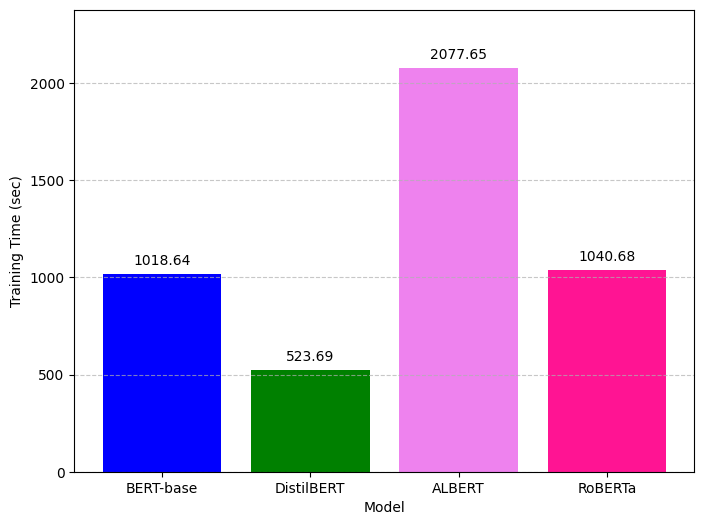

In [7]:
#Training Time Comparison of Transformer Models.
import matplotlib.pyplot as plt

models = ['BERT-base', 'DistilBERT', 'ALBERT', 'RoBERTa']
training_time = [1018.64, 523.69, 2077.65, 1040.68]

bar_colors = ['blue', 'green', 'violet', '#FF1493']

plt.figure(figsize=(8, 6))

plt.bar(models, training_time, color=bar_colors)

plt.xlabel('Model')
plt.ylabel('Training Time (sec)')

plt.ylim(0, max(training_time) + 300)
for i in range(len(models)):
    plt.text(models[i], training_time[i] + 30, f'{training_time[i]:.2f}',
             ha='center', va='bottom', fontsize=10, color='black')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model.load_state_dict(torch.load('distilbert_model_trained.pth'))

model.eval()

data = pd.read_csv(r"C:\Users\aaa\Downloads\balanced_copopsofinaldataset_new1.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

val_dataset = Dataset(val_encodings, y_val.tolist())
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aaa\AppData\Local\Temp\ipykernel_5072\1348071711.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they 

In [ ]:
from collections import defaultdict
import torch

misclassifications = defaultdict(list)

all_preds = []
all_labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

for batch in torch.utils.data.DataLoader(val_dataset, batch_size=64):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    all_preds.append(preds)
    all_labels.append(labels)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

misclassified_idx = (all_preds != all_labels).nonzero(as_tuple=True)[0]

for idx in misclassified_idx:
    true_label = all_labels[idx].item()
    pred_label = all_preds[idx].item()
    misclassifications[true_label].append(pred_label)

total_misclassified = sum(len(misclassifications[true_label]) for true_label in misclassifications)

total_validation_set = len(all_labels)

print(f"Total validation set: {total_validation_set}")
print(f"Total misclassified instances in the validation dataset: {total_misclassified}")

Total validation set: 1790
Total misclassified instances in the validation dataset: 24


In [ ]:
from collections import Counter

class_counts = Counter(all_labels.cpu().numpy())

print("Class counts in the validation set:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} instances")

Class counts in the validation set:
Class 2: 428 instances
Class 0: 500 instances
Class 3: 430 instances
Class 1: 432 instances


In [ ]:
misclassification_details = {}

for true_label, predicted_labels in misclassifications.items():
    count_per_class = defaultdict(int)
    for pred_label in predicted_labels:
        count_per_class[pred_label] += 1

    misclassification_details[true_label] = count_per_class

print("\nMisclassification count per class (detailed, sorted by total misclassifications):")
sorted_misclassifications = sorted(misclassification_details.items(), key=lambda x: sum(x[1].values()), reverse=True)

for true_label, details in sorted_misclassifications:
    misclassified_count = sum(details.values())
    print(f"Class {true_label}: {misclassified_count} misclassifications ", end="(")

    misclass_str = ", ".join([f"Class {k}: {v} misclassifications" for k, v in details.items()])
    print(f"{misclass_str})")


Misclassification count per class (detailed, sorted by total misclassifications):
Class 0: 15 misclassifications (Class 3: 14 misclassifications, Class 2: 1 misclassifications)
Class 3: 7 misclassifications (Class 0: 6 misclassifications, Class 2: 1 misclassifications)
Class 1: 1 misclassifications (Class 0: 1 misclassifications)
Class 2: 1 misclassifications (Class 0: 1 misclassifications)


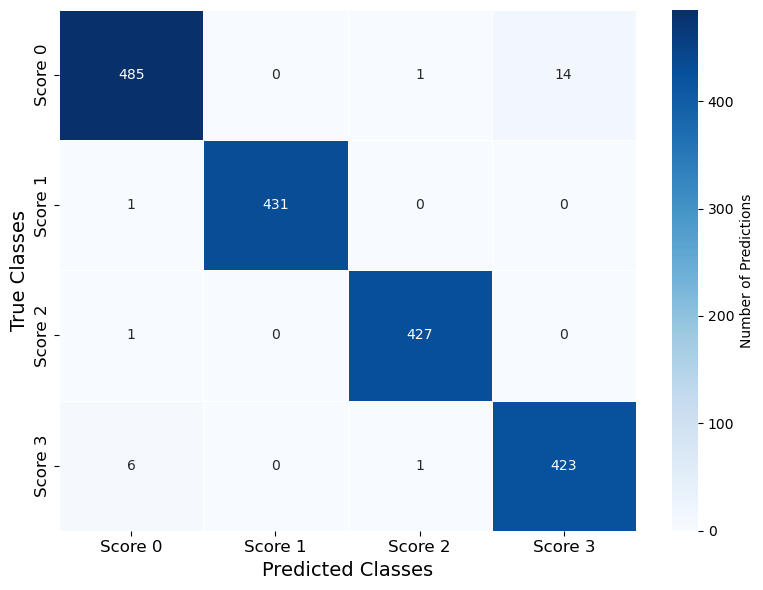

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

conf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Score 0', 'Score 1', 'Score 2', 'Score 3'],
                 yticklabels=['Score 0', 'Score 1', 'Score 2', 'Score 3'],
                 cbar_kws={'label': 'Number of Predictions'},
                 linewidths=0.5)

plt.xlabel('Predicted Classes', fontsize=14)
plt.ylabel('True Classes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

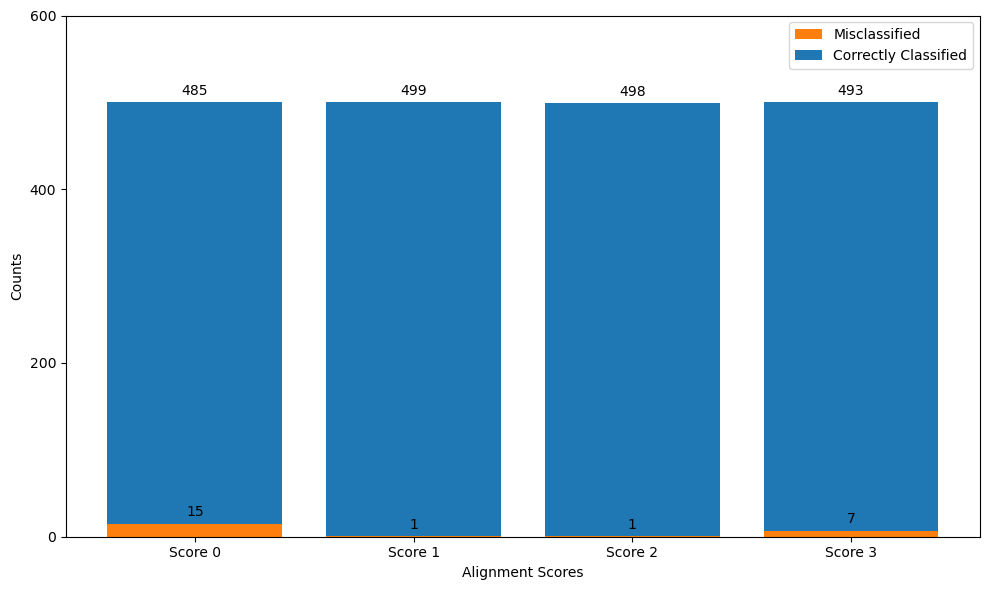

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

alignment_scores = ['Score 0', 'Score 1', 'Score 2', 'Score 3']
correct_classified = [485, 499, 498, 493]
misclassified = [15, 1, 1, 7]

index = np.arange(len(alignment_scores))

plt.figure(figsize=(10, 6))

plt.bar(index, misclassified, label='Misclassified', color='#ff7f0e')
plt.bar(index, correct_classified, bottom=misclassified, label='Correctly Classified', color='#1f77b4')

for i in range(len(alignment_scores)):
    plt.text(index[i], misclassified[i] + 5, f'{misclassified[i]}', ha='center', va='bottom', fontsize=10, color='black')
    plt.text(index[i], misclassified[i] + correct_classified[i] + 5, f'{correct_classified[i]}', ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Alignment Scores')
plt.ylabel('Counts')
plt.xticks(index, alignment_scores)
plt.legend()

plt.ylim(0, 600)
plt.yticks(np.arange(0, 601, 200))

plt.tight_layout()
plt.show()

In [ ]:
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model.load_state_dict(torch.load('distilbert_model_trained.pth'))

model.eval()

data = pd.read_csv(r"C:\Users\aaa\Downloads\copopsofinaldataset.csv")
data = data[['Course Identifier', 'CO Identifier', 'CO Description', 'PO/PSO Identifier', 'PO/PSO Description', 'Score (0-3)']]

X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

encodings = tokenizer(
    list(X_co),
    list(X_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

dataset = Dataset(encodings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

predictions = []

model = model.to(device)

for batch in dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    predictions.extend(preds.cpu().numpy())

data['Predicted Class'] = predictions

data.to_csv(r"C:\Users\aaa\Downloads\copopsofinaldataset_with_predictions_newnew.csv", index=False)
print("Predictions added and dataset saved successfully.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aaa\AppData\Local\Temp\ipykernel_5072\873838662.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they a

Predictions added and dataset saved successfully.


In [ ]:
mismatches = (data['Score (0-3)'] != data['Predicted Class']).sum()

print(f"Number of mismatches: {mismatches}")

Number of mismatches: 16


In [ ]:
mismatch_counts = data.groupby('Course Identifier').apply(
    lambda group: (group['Score (0-3)'] != group['Predicted Class']).sum()
)

print("Mismatch counts for each Course Identifier:")
print(mismatch_counts)

mismatch_counts.to_csv(r"C:\Users\aaa\Downloads\mismatch_counts_by_course.csv", header=True)

Mismatch counts for each Course Identifier:
Course Identifier
CI20303          0
CI40136          1
CS23317          0
CS30144          1
CS40141          0
CS42175          3
CS42177          1
CSE21303         2
CSE21308         1
CSE21310         0
CSE23304         0
CSE23305         0
CSE23306         0
CSE23307         0
CSE23309         1
CSE23312         0
CSE23316         0
CSE23320         0
CSE23450         0
IT40138          3
IT42123          3
Major Project    0
dtype: int64


C:\Users\aaa\AppData\Local\Temp\ipykernel_5072\472683516.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mismatch_counts = data.groupby('Course Identifier').apply(


In [ ]:
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model.load_state_dict(torch.load('distilbert_model_trained.pth'))

model.eval()

data = pd.read_csv(r"C:\Users\aaa\Downloads\co-po-pso newcollegedataset.csv")
data = data[['Course Identifier', 'CO Identifier', 'CO Description', 'PO/PSO Identifier', 'PO/PSO Description', 'Score (0-3)']]

X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

encodings = tokenizer(
    list(X_co),
    list(X_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

dataset = Dataset(encodings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

predictions = []

model = model.to(device)

for batch in dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    predictions.extend(preds.cpu().numpy())
data['Predicted Class'] = predictions

data.to_csv(r"C:\Users\aaa\Downloads\copopsonewcollegedataset_with_predictions_newnew.csv", index=False)
print("Predictions added and dataset saved successfully.")

C:\Users\aaa\anaconda3\envs\ml_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aaa\AppData\Local\Temp\ipykernel_24096\3275049363.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted

Predictions added and dataset saved successfully.


In [ ]:
import os
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

device = torch.device("cpu")

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model.load_state_dict(torch.load('distilbert_model_trained.pth', map_location=device))
model.to(device)
model.eval()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict_proba(text_pairs):
    encodings = tokenizer(
        [text for text in text_pairs],
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aaa\AppData\Local\Temp\ipykernel_15000\2882570338.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they

In [ ]:
co_text = "Understand the fundamental concepts of various data structures and their usage."
po_pso_text = "Conduct investigations of complex problems: Use research-based knowledge and including design of experiments, analysis and interpretation of data, and synthesis of the information to provide valid conclusions."

text_pair = f"{co_text} [SEP] {po_pso_text}"

explainer = LimeTextExplainer(class_names=["No Relation (0)", "Moderate (1)", "Moderate (2)", "High Relation (3)"])

explanation = explainer.explain_instance(
    text_pair,
    predict_proba,
    num_features=10
)

explanation.show_in_notebook(text=True)

In [ ]:
co_text = "Understand the fundamental concepts of various data structures and their usage."
po_pso_text = "Ability to use knowledge of ethical and management principles required to work in a team as well as to lead a team."

text_pair = f"{co_text} [SEP] {po_pso_text}"

explainer = LimeTextExplainer(class_names=["No Relation (0)", "Moderate (1)", "Moderate (2)", "High Relation (3)"])

explanation = explainer.explain_instance(
    text_pair,
    predict_proba,
    num_features=10
)

explanation.show_in_notebook(text=True)

In [ ]:
co_text = "Understand the fundamental concepts of various data structures and their usage."
po_pso_text = "Life-long learning: Recognize the need for, and have the preparation and ability to engage in independent and life-long learning in the broadest context of technological change."

text_pair = f"{co_text} [SEP] {po_pso_text}"

explainer = LimeTextExplainer(class_names=["No Relation (0)", "Moderate (1)", "Moderate (2)", "High Relation (3)"])

explanation = explainer.explain_instance(
    text_pair,
    predict_proba,
    num_features=10
)

explanation.show_in_notebook(text=True)

In [ ]:
co_text = "Understand the fundamental concepts of various data structures and their usage."
po_pso_text = "Engineering knowledge: Apply the knowledge of mathematics, science, engineering fundamentals, and an engineering specialization for the solution of complex engineering problems."

text_pair = f"{co_text} [SEP] {po_pso_text}"

explainer = LimeTextExplainer(class_names=["No Relation (0)", "Moderate (1)", "Moderate (2)", "High Relation (3)"])

explanation = explainer.explain_instance(
    text_pair,
    predict_proba,
    num_features=10
)

explanation.show_in_notebook(text=True)

In [ ]:
#DistilBERT Model with Augmentation (Without Shuffling).
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

data = pd.read_csv(r"C:\Users\aaa\Downloads\balanced_copopsofinaldataset_new1_withoutshuffling.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

distilbert_model_save_path = 'distilbert_model_trained_aug_withoutshuff.pth'
torch.save(model.state_dict(), distilbert_model_save_path)

print(f"Model saved to {distilbert_model_save_path}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:50<00:00,  2.22it/s]


Epoch 1/10, Train Loss: 0.0113, Train Acc: 0.7345, Train Precision: 0.7404, Train Recall: 0.7345, Train F1: 0.7350, Valid Loss: 0.0061, Valid Acc: 0.8637, Valid Precision: 0.8692, Valid Recall: 0.8637, Valid F1: 0.8626, Epoch Time: 54.72 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:47<00:00,  2.38it/s]


Epoch 2/10, Train Loss: 0.0043, Train Acc: 0.9082, Train Precision: 0.9082, Train Recall: 0.9082, Train F1: 0.9076, Valid Loss: 0.0039, Valid Acc: 0.9073, Valid Precision: 0.9098, Valid Recall: 0.9073, Valid F1: 0.9056, Epoch Time: 51.25 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:47<00:00,  2.36it/s]


Epoch 3/10, Train Loss: 0.0022, Train Acc: 0.9507, Train Precision: 0.9504, Train Recall: 0.9507, Train F1: 0.9504, Valid Loss: 0.0029, Valid Acc: 0.9358, Valid Precision: 0.9364, Valid Recall: 0.9358, Valid F1: 0.9348, Epoch Time: 51.62 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:47<00:00,  2.34it/s]


Epoch 4/10, Train Loss: 0.0015, Train Acc: 0.9682, Train Precision: 0.9681, Train Recall: 0.9682, Train F1: 0.9681, Valid Loss: 0.0031, Valid Acc: 0.9335, Valid Precision: 0.9350, Valid Recall: 0.9335, Valid F1: 0.9324, Epoch Time: 52.11 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:47<00:00,  2.34it/s]


Epoch 5/10, Train Loss: 0.0011, Train Acc: 0.9754, Train Precision: 0.9754, Train Recall: 0.9754, Train F1: 0.9754, Valid Loss: 0.0015, Valid Acc: 0.9698, Valid Precision: 0.9697, Valid Recall: 0.9698, Valid F1: 0.9697, Epoch Time: 52.20 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.33it/s]


Epoch 6/10, Train Loss: 0.0005, Train Acc: 0.9906, Train Precision: 0.9907, Train Recall: 0.9906, Train F1: 0.9906, Valid Loss: 0.0040, Valid Acc: 0.9374, Valid Precision: 0.9418, Valid Recall: 0.9374, Valid F1: 0.9375, Epoch Time: 52.35 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.33it/s]


Epoch 7/10, Train Loss: 0.0007, Train Acc: 0.9853, Train Precision: 0.9853, Train Recall: 0.9853, Train F1: 0.9853, Valid Loss: 0.0017, Valid Acc: 0.9648, Valid Precision: 0.9646, Valid Recall: 0.9648, Valid F1: 0.9646, Epoch Time: 52.35 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.33it/s]


Epoch 8/10, Train Loss: 0.0003, Train Acc: 0.9941, Train Precision: 0.9941, Train Recall: 0.9941, Train F1: 0.9941, Valid Loss: 0.0015, Valid Acc: 0.9754, Valid Precision: 0.9753, Valid Recall: 0.9754, Valid F1: 0.9753, Epoch Time: 52.40 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.33it/s]


Epoch 9/10, Train Loss: 0.0006, Train Acc: 0.9869, Train Precision: 0.9869, Train Recall: 0.9869, Train F1: 0.9869, Valid Loss: 0.0017, Valid Acc: 0.9676, Valid Precision: 0.9678, Valid Recall: 0.9676, Valid F1: 0.9675, Epoch Time: 52.38 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:48<00:00,  2.33it/s]


Epoch 10/10, Train Loss: 0.0003, Train Acc: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943, Valid Loss: 0.0013, Valid Acc: 0.9760, Valid Precision: 0.9759, Valid Recall: 0.9760, Valid F1: 0.9759, Epoch Time: 52.38 seconds
Total training time: 523.77 seconds
Model saved to distilbert_model_trained_aug_withoutshuff.pth


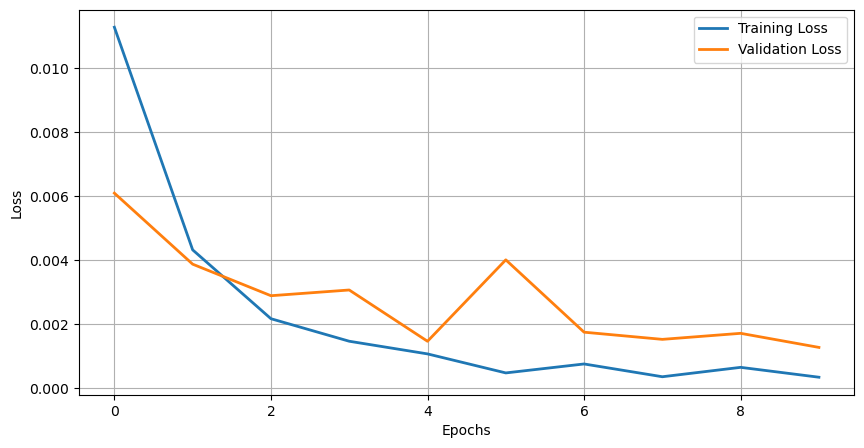

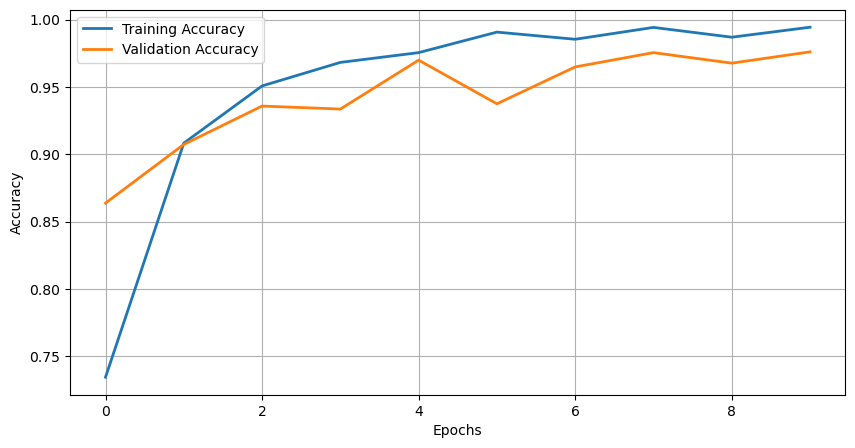

In [ ]:
#DistilBERT Model Plot with Augmentation (Without Shuffling) plot
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

In [ ]:
#DistilBERT model before Augmentation.
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
import time
from tqdm import tqdm

data = pd.read_csv(r"C:\Users\aaa\Downloads\copopsofinaldataset.csv")
data = data[['CO Description', 'PO/PSO Description', 'Score (0-3)']]
X_co = data['CO Description']
X_po_pso = data['PO/PSO Description']
y = data['Score (0-3)']

X_train_co, X_val_co, X_train_po_pso, X_val_po_pso, y_train, y_val = train_test_split(
    X_co, X_po_pso, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

device = torch.device('cuda')
model.to(device)

train_encodings = tokenizer(
    list(X_train_co),
    list(X_train_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val_co),
    list(X_val_po_pso),
    truncation=True,
    padding=True,
    max_length=512
)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train.tolist())
val_dataset = Dataset(val_encodings, y_val.tolist())

def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == labels).float().mean()

def compute_metrics(preds, labels):
    preds = preds.argmax(dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    return precision, recall, f1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 10
batch_size = 64
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, batch in enumerate(tqdm(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True))):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        train_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
        all_train_preds.append(outputs.logits)
        all_train_labels.append(labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataset)
    avg_train_acc = train_correct / len(train_dataset)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    train_precision, train_recall, train_f1 = compute_metrics(all_train_preds, all_train_labels)

    model.eval()
    valid_loss = 0
    valid_correct = 0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            valid_correct += compute_accuracy(outputs.logits, labels).item() * labels.size(0)
            all_valid_preds.append(outputs.logits)
            all_valid_labels.append(labels)

    avg_valid_loss = valid_loss / len(val_dataset)
    avg_valid_acc = valid_correct / len(val_dataset)
    valid_losses.append(avg_valid_loss)
    valid_accs.append(avg_valid_acc)

    all_valid_preds = torch.cat(all_valid_preds)
    all_valid_labels = torch.cat(all_valid_labels)

    val_precision, val_recall, val_f1 = compute_metrics(all_valid_preds, all_valid_labels)
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.4f}, '
          f'Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid F1: {val_f1:.4f}, '
          f'Epoch Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

distilbert_model_save_path = 'distilbert_model_trained_preaug.pth'
torch.save(model.state_dict(), distilbert_model_save_path)

print(f"Model saved to {distilbert_model_save_path}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.53it/s]


Epoch 1/10, Train Loss: 0.0135, Train Acc: 0.6753, Train Precision: 0.6492, Train Recall: 0.6753, Train F1: 0.6448, Valid Loss: 0.0095, Valid Acc: 0.8261, Valid Precision: 0.7729, Valid Recall: 0.8261, Valid F1: 0.7943, Epoch Time: 10.07 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.58it/s]


Epoch 2/10, Train Loss: 0.0091, Train Acc: 0.8213, Train Precision: 0.7654, Train Recall: 0.8213, Train F1: 0.7900, Valid Loss: 0.0088, Valid Acc: 0.8315, Valid Precision: 0.7802, Valid Recall: 0.8315, Valid F1: 0.7999, Epoch Time: 9.89 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.57it/s]


Epoch 3/10, Train Loss: 0.0084, Train Acc: 0.8213, Train Precision: 0.7662, Train Recall: 0.8213, Train F1: 0.7903, Valid Loss: 0.0084, Valid Acc: 0.8288, Valid Precision: 0.7720, Valid Recall: 0.8288, Valid F1: 0.7990, Epoch Time: 9.91 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.57it/s]


Epoch 4/10, Train Loss: 0.0077, Train Acc: 0.8322, Train Precision: 0.7747, Train Recall: 0.8322, Train F1: 0.8015, Valid Loss: 0.0081, Valid Acc: 0.8261, Valid Precision: 0.7980, Valid Recall: 0.8261, Valid F1: 0.7996, Epoch Time: 9.92 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.56it/s]


Epoch 5/10, Train Loss: 0.0067, Train Acc: 0.8471, Train Precision: 0.8153, Train Recall: 0.8471, Train F1: 0.8268, Valid Loss: 0.0079, Valid Acc: 0.8207, Valid Precision: 0.8177, Valid Recall: 0.8207, Valid F1: 0.7972, Epoch Time: 9.97 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.55it/s]


Epoch 6/10, Train Loss: 0.0056, Train Acc: 0.8696, Train Precision: 0.8524, Train Recall: 0.8696, Train F1: 0.8545, Valid Loss: 0.0072, Valid Acc: 0.8397, Valid Precision: 0.8310, Valid Recall: 0.8397, Valid F1: 0.8218, Epoch Time: 10.00 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.55it/s]


Epoch 7/10, Train Loss: 0.0048, Train Acc: 0.8865, Train Precision: 0.8799, Train Recall: 0.8865, Train F1: 0.8758, Valid Loss: 0.0080, Valid Acc: 0.8261, Valid Precision: 0.8111, Valid Recall: 0.8261, Valid F1: 0.8163, Epoch Time: 10.00 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.54it/s]


Epoch 8/10, Train Loss: 0.0039, Train Acc: 0.9083, Train Precision: 0.9041, Train Recall: 0.9083, Train F1: 0.9035, Valid Loss: 0.0088, Valid Acc: 0.8288, Valid Precision: 0.8034, Valid Recall: 0.8288, Valid F1: 0.8131, Epoch Time: 10.05 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.54it/s]


Epoch 9/10, Train Loss: 0.0035, Train Acc: 0.9137, Train Precision: 0.9093, Train Recall: 0.9137, Train F1: 0.9096, Valid Loss: 0.0091, Valid Acc: 0.8261, Valid Precision: 0.8049, Valid Recall: 0.8261, Valid F1: 0.8063, Epoch Time: 10.04 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.53it/s]


Epoch 10/10, Train Loss: 0.0030, Train Acc: 0.9341, Train Precision: 0.9307, Train Recall: 0.9341, Train F1: 0.9315, Valid Loss: 0.0093, Valid Acc: 0.8370, Valid Precision: 0.8290, Valid Recall: 0.8370, Valid F1: 0.8218, Epoch Time: 10.05 seconds
Total training time: 99.89 seconds
Model saved to distilbert_model_trained_preaug.pth


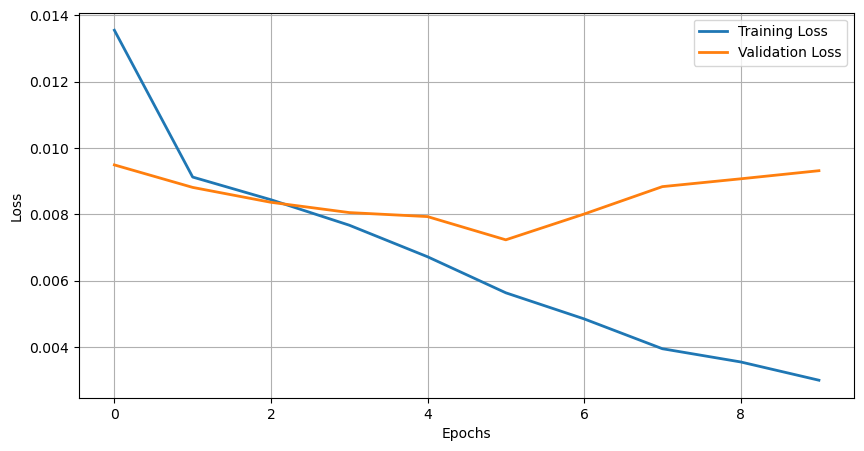

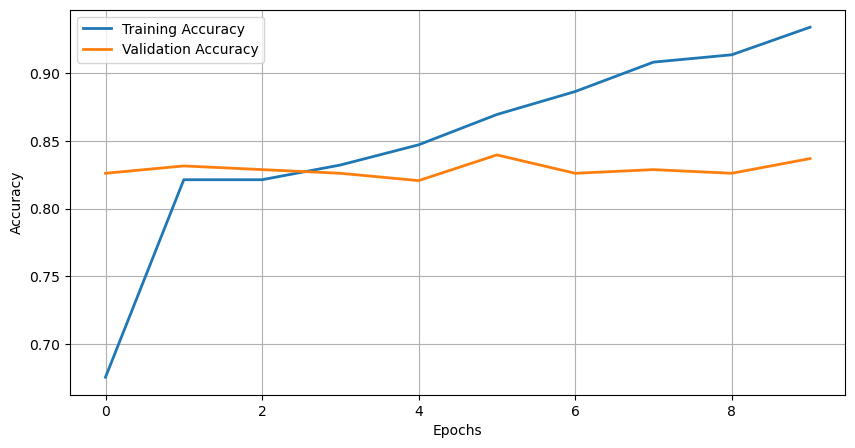

In [ ]:
#DistilBERT model plot before Augmentation.
import matplotlib.pyplot as plt

standard_blue = '#1f77b4'
standard_orange = '#ff7f0e'

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_losses, label='Validation Loss', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color=standard_blue, linestyle='-', linewidth=2)
plt.plot(valid_accs, label='Validation Accuracy', color=standard_orange, linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()